# Professionalism & Reproducibility
Homework 1: The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1st, 2015 through September 30th, 2024

## Acknowledgement
Part of the code is taken from wp_article_views_example.ipynb provided by Dr. David W. McDonald


In [11]:
import json, time, urllib.parse
import requests
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math

The example relies on some constants that help make the code a bit more readable.

In [12]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

REQUEST_HEADERS = {
    'User-Agent': '<tchiang0@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",             # desktop, mobile-app, mobile-web
    "agent":       "user",
    "article":     "",             # article title
    "granularity": "monthly",
    "start":       "2015070100",   # start date July 1, 2015
    "end":         "2024093000"    # end date September 30, 2024
}

## Gather Article titles

Article titles are collected from the rare-disease_cleaned.AUG.2024.csv file

In [13]:
rare_disease_cleaned_csv = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')

# CONSTANT
ARTICLE_TITLES = rare_disease_cleaned_csv["disease"].tolist()

request_pageviews_per_article takes the **ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE**, **ARTICLE_TITLES**, and **ACCESS** constants and calls the wikimedia API to get 
```
{
  "items": [
    {
      "project": "en.wikipedia",
      "article": "article_title",
      "granularity": "monthly",
      "timestamp": "2015070100",
      "access": "",  # desktop, mobile-app, mobile-web
      "agent": "user",
      "views": int
    },...] }
```
for each article

In [14]:
def request_pageviews_per_article(article_title = None, 
                                  access_device = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    """
    API call get pageviews of the ariticle based on request type
    Returns json response body
    """
    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    if access_device:
        request_template['access'] = access_device

    if not request_template['access']:
        raise Exception("Must supply a device [desktop, mobile-app, mobile-web] to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    # mark no characters as safe since we want / to be converted to %2f
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


### Monthly desktop access
Monthly desktop page traffic is based on one single request \
**DESKTOP_ACCESS** is a constant to pass in the request_pageviews_per_article function

In [15]:
DESKTOP_ACCESS = 'desktop'

Collect all pageviews using desktop access from July 1st, 2015 through September 30, 2024 \
**article_desktop_dict** has article title as key and the list of pageviews as value

In [16]:
# keep track of all montly pageview record of each article by desktop access
# article: [list of pageview records by desktop access]
article_desktop_dict = {}

for article in ARTICLE_TITLES:
    print(f"Getting pageview data for: {article} using {DESKTOP_ACCESS}")
    views = request_pageviews_per_article(article, DESKTOP_ACCESS)
    for month in views['items']:
        del month['access']  # delete "access" key to avoid confusion
    article_desktop_dict[article] = views['items']

Getting pageview data for: Klinefelter syndrome using desktop
Getting pageview data for: Aarskog–Scott syndrome using desktop
Getting pageview data for: Abetalipoproteinemia using desktop
Getting pageview data for: MT-TP using desktop
Getting pageview data for: Ablepharon macrostomia syndrome using desktop
Getting pageview data for: Acanthocheilonemiasis using desktop
Getting pageview data for: Acanthosis nigricans using desktop
Getting pageview data for: Aceruloplasminemia using desktop
Getting pageview data for: Megaesophagus using desktop
Getting pageview data for: Achard–Thiers syndrome using desktop
Getting pageview data for: Achondrogenesis using desktop
Getting pageview data for: Achondroplasia using desktop
Getting pageview data for: Dwarfism using desktop
Getting pageview data for: Osteochondrodysplasia using desktop
Getting pageview data for: Fibroblast growth factor receptor 3 using desktop
Getting pageview data for: Vestibular schwannoma using desktop
Getting pageview data 

Save the desktop access pageview data into a json file named rare-disease_monthly_desktop_start201507-end202409.json

In [44]:
with open("rare-disease_monthly_desktop_start201507-end202409.json", "w") as outfile: 
    json.dump(article_desktop_dict, outfile, indent=4)

### Monthly desktop access
Monthly desktop page traffic is based on one single request. \
**MOBILE_APP** and **MOBILE_WEB** are constants to pass in the request_pageviews_per_article function

In [18]:
MOBILE_APP = 'mobile-app'
MOBILE_WEB = 'mobile-web'

Collect all pageviews using mobile-app and mobile-web access from July 1st, 2015 through September 30, 2024 \
**article_mobile_dict** has article title as key and the list of pageviews as value (combining mobile-app and mobile-web)

In [19]:
# keep track of all montly pageview record of each article by mobile-app access first
# article: [list of pageview records by mobile-app]
article_mobile_dict = {}

for article in ARTICLE_TITLES:
    print(f"Getting pageview data for: {article} using {MOBILE_APP}")
    views = request_pageviews_per_article(article, MOBILE_APP)
    for month in views['items']:
        del month['access']  # delete "access" to avoid confusion
    article_mobile_dict[article] = views['items']

Getting pageview data for: Klinefelter syndrome using mobile-app
Getting pageview data for: Aarskog–Scott syndrome using mobile-app
Getting pageview data for: Abetalipoproteinemia using mobile-app
Getting pageview data for: MT-TP using mobile-app
Getting pageview data for: Ablepharon macrostomia syndrome using mobile-app
Getting pageview data for: Acanthocheilonemiasis using mobile-app
Getting pageview data for: Acanthosis nigricans using mobile-app
Getting pageview data for: Aceruloplasminemia using mobile-app
Getting pageview data for: Megaesophagus using mobile-app
Getting pageview data for: Achard–Thiers syndrome using mobile-app
Getting pageview data for: Achondrogenesis using mobile-app
Getting pageview data for: Achondroplasia using mobile-app
Getting pageview data for: Dwarfism using mobile-app
Getting pageview data for: Osteochondrodysplasia using mobile-app
Getting pageview data for: Fibroblast growth factor receptor 3 using mobile-app
Getting pageview data for: Vestibular sc

After acquring all pageviews from each article using mobile-app access, mobile-web is next and combined with the pageviews using mobile-app to get one single "mobile" access pageview data

In [20]:
for article in ARTICLE_TITLES:
    print(f"Getting pageview data for: {article} using {MOBILE_WEB}")
    views = request_pageviews_per_article(article, MOBILE_WEB)
    for idx, month in enumerate(views["items"]):
        del month['access']
        article_mobile_dict[article][idx]["views"] += month['views']  # combine mobile-app and mobile-web pageviews

Getting pageview data for: Klinefelter syndrome using mobile-web
Getting pageview data for: Aarskog–Scott syndrome using mobile-web
Getting pageview data for: Abetalipoproteinemia using mobile-web
Getting pageview data for: MT-TP using mobile-web
Getting pageview data for: Ablepharon macrostomia syndrome using mobile-web
Getting pageview data for: Acanthocheilonemiasis using mobile-web
Getting pageview data for: Acanthosis nigricans using mobile-web
Getting pageview data for: Aceruloplasminemia using mobile-web
Getting pageview data for: Megaesophagus using mobile-web
Getting pageview data for: Achard–Thiers syndrome using mobile-web
Getting pageview data for: Achondrogenesis using mobile-web
Getting pageview data for: Achondroplasia using mobile-web
Getting pageview data for: Dwarfism using mobile-web
Getting pageview data for: Osteochondrodysplasia using mobile-web
Getting pageview data for: Fibroblast growth factor receptor 3 using mobile-web
Getting pageview data for: Vestibular sc

Save the mobile (mobile-app & mobile-web) access pageview data into a json file named rare-disease_monthly_mobile_start201507-end202409.json

In [52]:
with open('rare-disease_monthly_mobile_start201507-end202409.json', 'w') as outfile:
    json.dump(article_mobile_dict, outfile, indent=4)

Sum up the total pageviews of each article by combining the pageview access by desktop and mobile \
**article_total** has article_title as key and list of combined pageviews as value

In [22]:
# keep track of all montly pageview record of each article by desktop and mobile (mobile-app & mobile-web) access first
# article: [list of pageview records by desktop and mobile (mobile-app & mobile-web)]
article_total = {}

for article, article_desktop_page_view_list in article_desktop_dict.items():
    tmp = copy.deepcopy(article_mobile_dict[article])  # deepcopy to avoid changing article_mobile_dict 
    for idx, article_desktop_month in enumerate(article_desktop_page_view_list):
        tmp[idx]['views'] += article_desktop_month['views']  # combined views
    article_total[article] = tmp

Save the desktop and mobile (mobile-app & mobile-web) access pageview data into a json file named rare-disease_monthly_cumulative_start201507-end202409.json

In [53]:
with open('rare-disease_monthly_cumulative_start201507-end202409.json', 'w') as outfile:
    json.dump(article_total, outfile, indent=4)

## Step 2: Analysis

### Maximum Average and Minimum Average
The first graph contains time series for the articles that have the **highest average page requests** and the **lowest average page requests** for desktop access and mobile access over the entire time series.

calculate_avg_page_view takes either **article_desktop_dict** or **article_mobile_dict** and return a dictionary of average pageviews for each article depending on the access type.

Returns 
```
{article title: average pageview over entire available months of data}
```

In [24]:
def calculate_avg_page_view(article_dict):
    """
    Return average pageview for each article over the entire available months of data
    """
    article_page_view_avg = {}
    for article, article_page_view_per_month in article_dict.items():
        total_page_view = 0
        for month in article_page_view_per_month:
            total_page_view += month['views']  # sum up total views 
        article_page_view_avg[article] = total_page_view / len(article_page_view_per_month)  # get average pageviews
    return article_page_view_avg

In [25]:
article_desktop_page_view_avg = calculate_avg_page_view(article_desktop_dict)
article_mobile_page_view_avg = calculate_avg_page_view(article_mobile_dict)

In [26]:
# sort average pageviews (ascending)
sorted_article_desktop_page_view_avg = list(sorted(article_desktop_page_view_avg.items(), key=lambda item: item[1]))
sorted_article_mobile_page_view_avg = list(sorted(article_mobile_page_view_avg.items(), key=lambda item: item[1]))

After sorting, the 1st entry (0-indexed) of each sorted pageview list has the article with the lowest average pageviews while the last entry has the highest average pageviews

In [27]:
print(f"Highest Average Page Request by Desktop: {sorted_article_desktop_page_view_avg[-1]}")
print(f"Lowest Average Page Request by Desktop: {sorted_article_desktop_page_view_avg[0]}")

Highest Average Page Request by Desktop: ('Black Death', 104859.31531531531)
Lowest Average Page Request by Desktop: ('Filippi Syndrome', 3.6176470588235294)


In [28]:
print(f"Highest Average Page Request by Mobile: {sorted_article_mobile_page_view_avg[-1]}")
print(f"Lowest Average Page Request by Mobile: {sorted_article_mobile_page_view_avg[0]}")

Highest Average Page Request by Mobile: ('Black Death', 177697.84684684683)
Lowest Average Page Request by Mobile: ('Filippi Syndrome', 1.588235294117647)


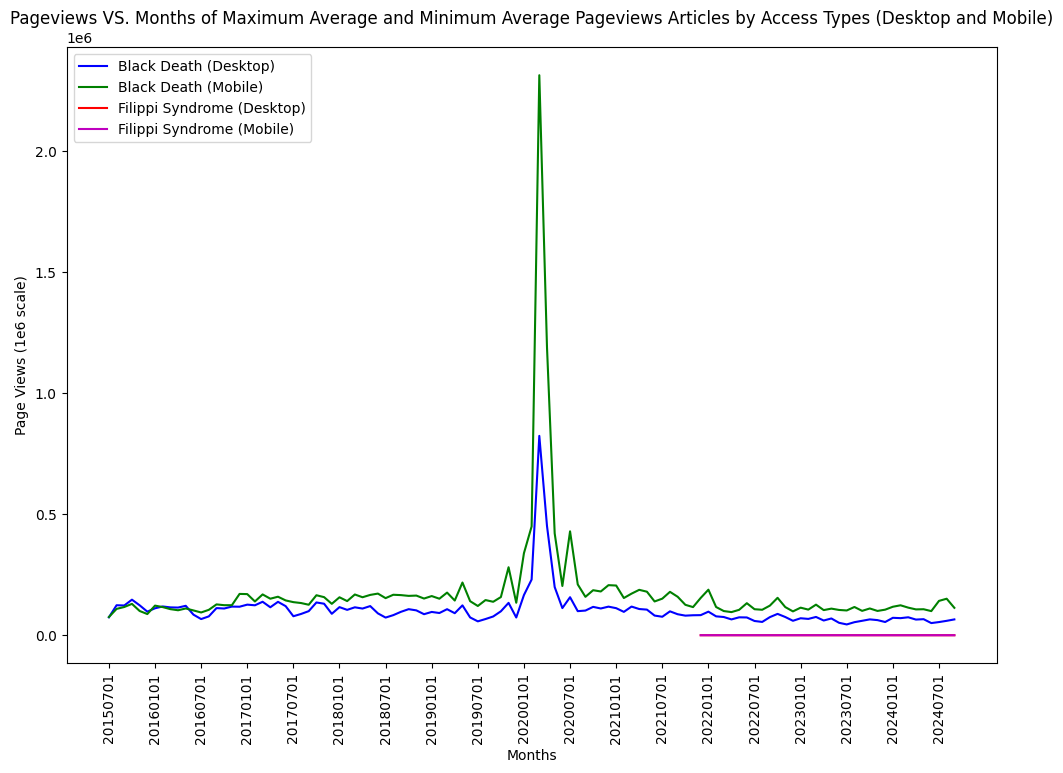

In [58]:
# get the months (x-axis) of black death and filippi syndrome
bd_months = [article['timestamp'][:-2] for article in article_desktop_dict['Black Death']]
fs_months = [article['timestamp'][:-2] for article in article_desktop_dict['Filippi Syndrome']]

# get the article pageviews (y-axis) of black death and filippi syndrome based on access type (desktop and mobile)
highest_avg_pr_desktop = [article['views'] for article in article_desktop_dict['Black Death']]
highest_avg_pr_mobile = [article['views'] for article in article_mobile_dict['Black Death']]
lowest_avg_pr_desktop = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Filippi Syndrome']]
lowest_avg_pr_mobile = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Filippi Syndrome']]

# plot graph
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(bd_months, highest_avg_pr_desktop, 'b-', label='Black Death (Desktop)')
ax1.plot(bd_months, highest_avg_pr_mobile, 'g-', label='Black Death (Mobile)')
ax1.plot(fs_months, lowest_avg_pr_desktop, 'r-', label='Filippi Syndrome (Desktop)')
ax1.plot(fs_months, lowest_avg_pr_mobile, 'm-', label='Filippi Syndrome (Mobile)')
ax1.set_xlabel('Months')
ax1.set_ylabel('Page Views (1e6 scale)')
ax1.tick_params('y')

# only display every 5 months to avoid x-axis crowding
ticks_to_display = range(0, len(bd_months), 6)  # Every 5th tick
plt.xticks(ticks_to_display, [bd_months[i] for i in ticks_to_display], rotation=90)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.title('Pageviews VS. Months of Maximum Average and Minimum Average Pageviews Articles by Access Types (Desktop and Mobile)')

plt.show()

Due to the difference in scale of highest and lowest pageviews, I decided to **log transform** the pageviews (y-axis) so that the trends are more easily visible

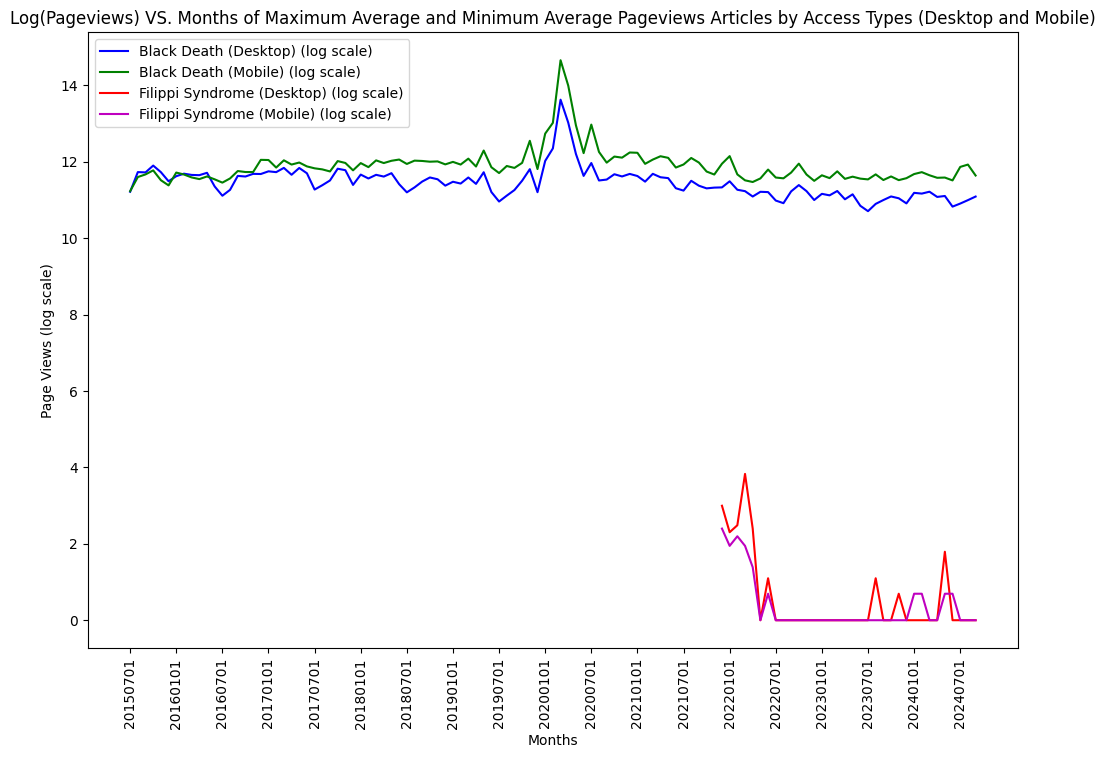

In [59]:
# get the months (x-axis) of black death and filippi syndrome
bd_months = [article['timestamp'][:-2] for article in article_desktop_dict['Black Death']]
fs_months = [article['timestamp'][:-2] for article in article_desktop_dict['Filippi Syndrome']]

# get the article pageviews (y-axis) of black death and filippi syndrome based on access type (desktop and mobile)
# log transform the pageviews
highest_avg_pr_desktop = [math.log(article['views']) for article in article_desktop_dict['Black Death']]
highest_avg_pr_mobile = [math.log(article['views']) for article in article_mobile_dict['Black Death']]
lowest_avg_pr_desktop = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Filippi Syndrome']]
lowest_avg_pr_mobile = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Filippi Syndrome']]

# plot graph
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(bd_months, highest_avg_pr_desktop, 'b-', label='Black Death (Desktop) (log scale)')
ax1.plot(bd_months, highest_avg_pr_mobile, 'g-', label='Black Death (Mobile) (log scale)')
ax1.plot(fs_months, lowest_avg_pr_desktop, 'r-', label='Filippi Syndrome (Desktop) (log scale)')
ax1.plot(fs_months, lowest_avg_pr_mobile, 'm-', label='Filippi Syndrome (Mobile) (log scale)')
ax1.set_xlabel('Months')
ax1.set_ylabel('Page Views (log scale)')
ax1.tick_params('y')

# only display every 5 months to avoid x-axis crowding
ticks_to_display = range(0, len(bd_months), 6)  # Every 5th tick
plt.xticks(ticks_to_display, [bd_months[i] for i in ticks_to_display], rotation=90)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.title('Log(Pageviews) VS. Months of Maximum Average and Minimum Average Pageviews Articles by Access Types (Desktop and Mobile)')

plt.show()

### Top 10 Peak Page Views
The second graph contains time series for the **top 10 article pages by largest (peak) page views** over the entire time series by access type.

find_article_mode_page_views takes either **article_desktop_dict** or **article_mobile_dict** and return a dictionary of maximum (mode) pageviews for each article depending on the access type.

Returns 
```
{article title: max pageview over entire available months of data}
```

In [31]:
def find_article_mode_page_views(article_dict):
    """
    Return max pageview (peak) for each article over the entire available months of data
    """
    article_mode_page_views = {}
    for article, article_page_view_per_month in article_dict.items():
        max_page_view = 0
        for month in article_page_view_per_month:
            max_page_view = max(max_page_view, month['views'])
        article_mode_page_views[article] = max_page_view
    return article_mode_page_views

Top 10 article max pageviews by desktop access \
Sort the resulting **article_desktop_mode_page_views** and access the top 10 articles with the highest max pageviews accessed by desktop

In [32]:
article_desktop_mode_page_views = find_article_mode_page_views(article_desktop_dict)
top_10_article_desktop_page_views = list(sorted(article_desktop_mode_page_views.items(), key=lambda x: x[1], reverse=True))[:10]
top_10_article_desktop_page_views

[('Pandemic', 1046521),
 ('Black Death', 823649),
 ('Chloroquine', 440897),
 ('Pfeiffer syndrome', 408153),
 ('Fibrodysplasia ossificans progressiva', 313785),
 ('Botulism', 302593),
 ('Robert Koch', 254656),
 ('Smallpox', 249177),
 ('Cleidocranial dysostosis', 191115),
 ('Amyotrophic lateral sclerosis', 186945)]

Top 10 article max pageviews by mobile (mobile-app and mobile-web) access \
Sort the resulting **article_mobile_mode_page_views** and access the top 10 articles with the highest max pageviews accessed by mobile

In [33]:
article_mobile_mode_page_views = find_article_mode_page_views(article_mobile_dict)
top_10_article_mobile_page_views = list(sorted(article_mobile_mode_page_views.items(), key=lambda x: x[1], reverse=True))[:10]
top_10_article_mobile_page_views

[('Black Death', 2313741),
 ('Pandemic', 2276916),
 ('Pfeiffer syndrome', 777886),
 ('Chloroquine', 777537),
 ('Stiff-person syndrome', 677927),
 ('Porphyria', 585872),
 ('Glioblastoma', 562173),
 ('Cleidocranial dysostosis', 485195),
 ('Botulism', 470273),
 ('Kawasaki disease', 448512)]

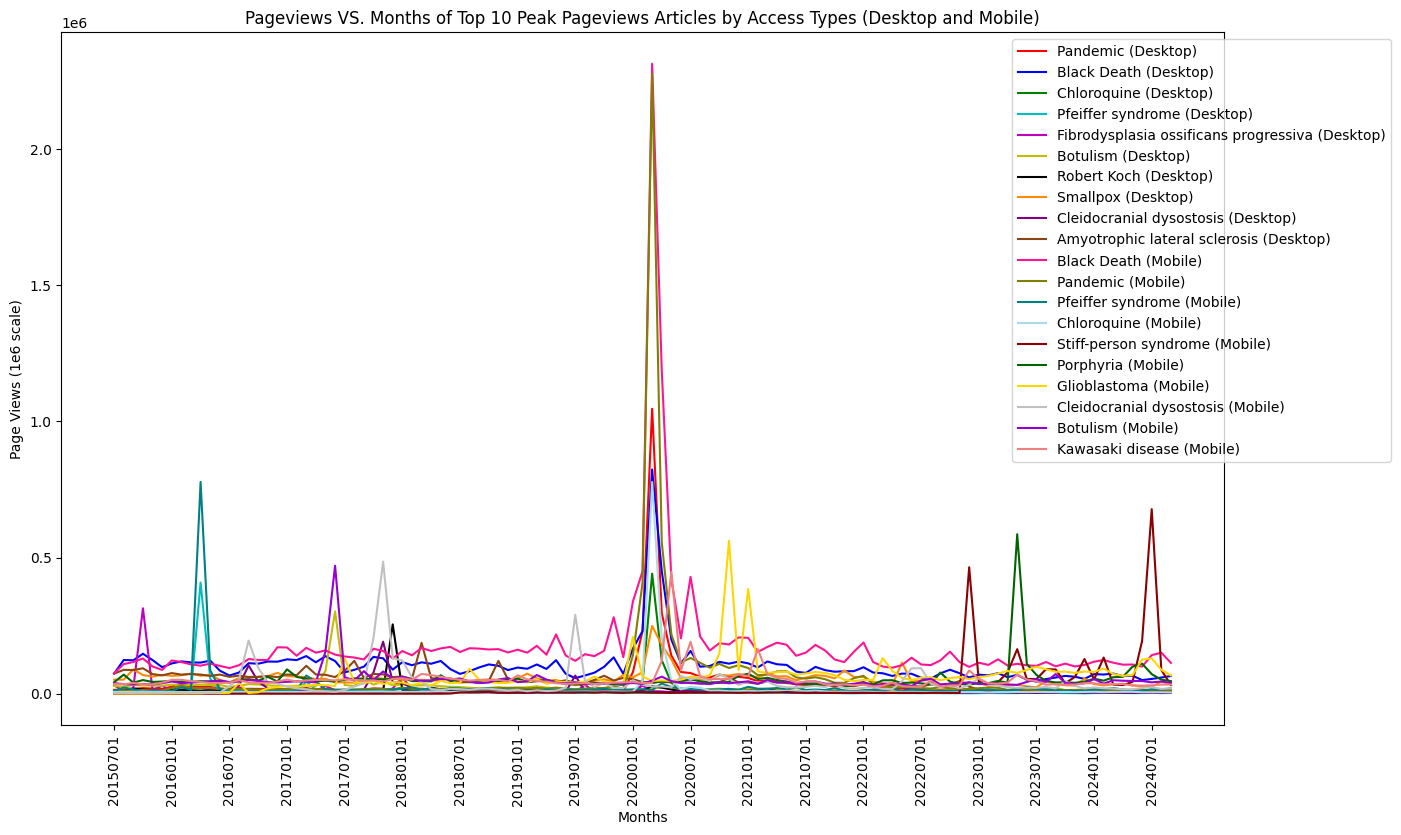

In [60]:
# get the months (x-axis) of all rare diseases
months = [article['timestamp'][:-2] for article in article_desktop_dict['Pandemic']]

# desktop article pageviews
pand_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Pandemic']]
bd_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Black Death']]
c_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Chloroquine']]
ps_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Pfeiffer syndrome']]
fop_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Fibrodysplasia ossificans progressiva']]
b_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Botulism']]
rk_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Robert Koch']]
s_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Smallpox']]
cd_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Cleidocranial dysostosis']]
als_dt = [article['views'] if article['views'] else 0 for article in article_desktop_dict['Amyotrophic lateral sclerosis']]

# mobile article pageviews
bd_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Black Death']]
pan_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Pandemic']]
ps_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Pfeiffer syndrome']]
c_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Chloroquine']]
sps_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Stiff-person syndrome']]
p_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Porphyria']]
g_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Glioblastoma']]
cd_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Cleidocranial dysostosis']]
b_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Botulism']]
kd_mo = [article['views'] if article['views'] else 0 for article in article_mobile_dict['Kawasaki disease']]

# 20 colors for each article in the graph
colors = [
    'r', 'b', 'g', 'c', 'm', 'y', 'k', '#FF8C00', '#800080', '#8B4513',
    '#FF1493', '#808000', '#008080', '#ADD8E6', '#8B0000', '#006400', 
    '#FFD700', '#C0C0C0', '#9400D3', '#F08080'
]

datasets = [pand_dt, bd_dt, c_dt, ps_dt, fop_dt, b_dt, rk_dt, s_dt, cd_dt, als_dt, 
            bd_mo, pan_mo, ps_mo, c_mo, sps_mo, p_mo, g_mo, cd_mo, b_mo, kd_mo]

labels = [
    'Pandemic (Desktop)', 'Black Death (Desktop)', 'Chloroquine (Desktop)',
    'Pfeiffer syndrome (Desktop)', 'Fibrodysplasia ossificans progressiva (Desktop)',
    'Botulism (Desktop)', 'Robert Koch (Desktop)', 'Smallpox (Desktop)',
    'Cleidocranial dysostosis (Desktop)', 'Amyotrophic lateral sclerosis (Desktop)',
    'Black Death (Mobile)', 'Pandemic (Mobile)', 'Pfeiffer syndrome (Mobile)', 'Chloroquine (Mobile)', 'Stiff-person syndrome (Mobile)',
    'Porphyria (Mobile)', 'Glioblastoma (Mobile)', 'Cleidocranial dysostosis (Mobile)', 'Botulism (Mobile)', 'Kawasaki disease (Mobile)'
]

# plot graph
fig, ax1 = plt.subplots(figsize=(15, 9))

for i in range(len(datasets)):
    ax1.plot(months, datasets[i], label=labels[i], color=colors[i], linestyle='-')

ax1.set_xlabel('Months')
ax1.set_ylabel('Page Views (1e6 scale)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Pageviews VS. Months of Top 10 Peak Pageviews Articles by Access Types (Desktop and Mobile)')

ticks_to_display = range(0, len(months), 6)  # Every 5th tick
plt.xticks(ticks_to_display, [months[i] for i in ticks_to_display], rotation=90)

plt.show()

Due to the difference in scale of pageviews, I decided to **log transform** the pageviews (y-axis) so that the trends are more easily visible

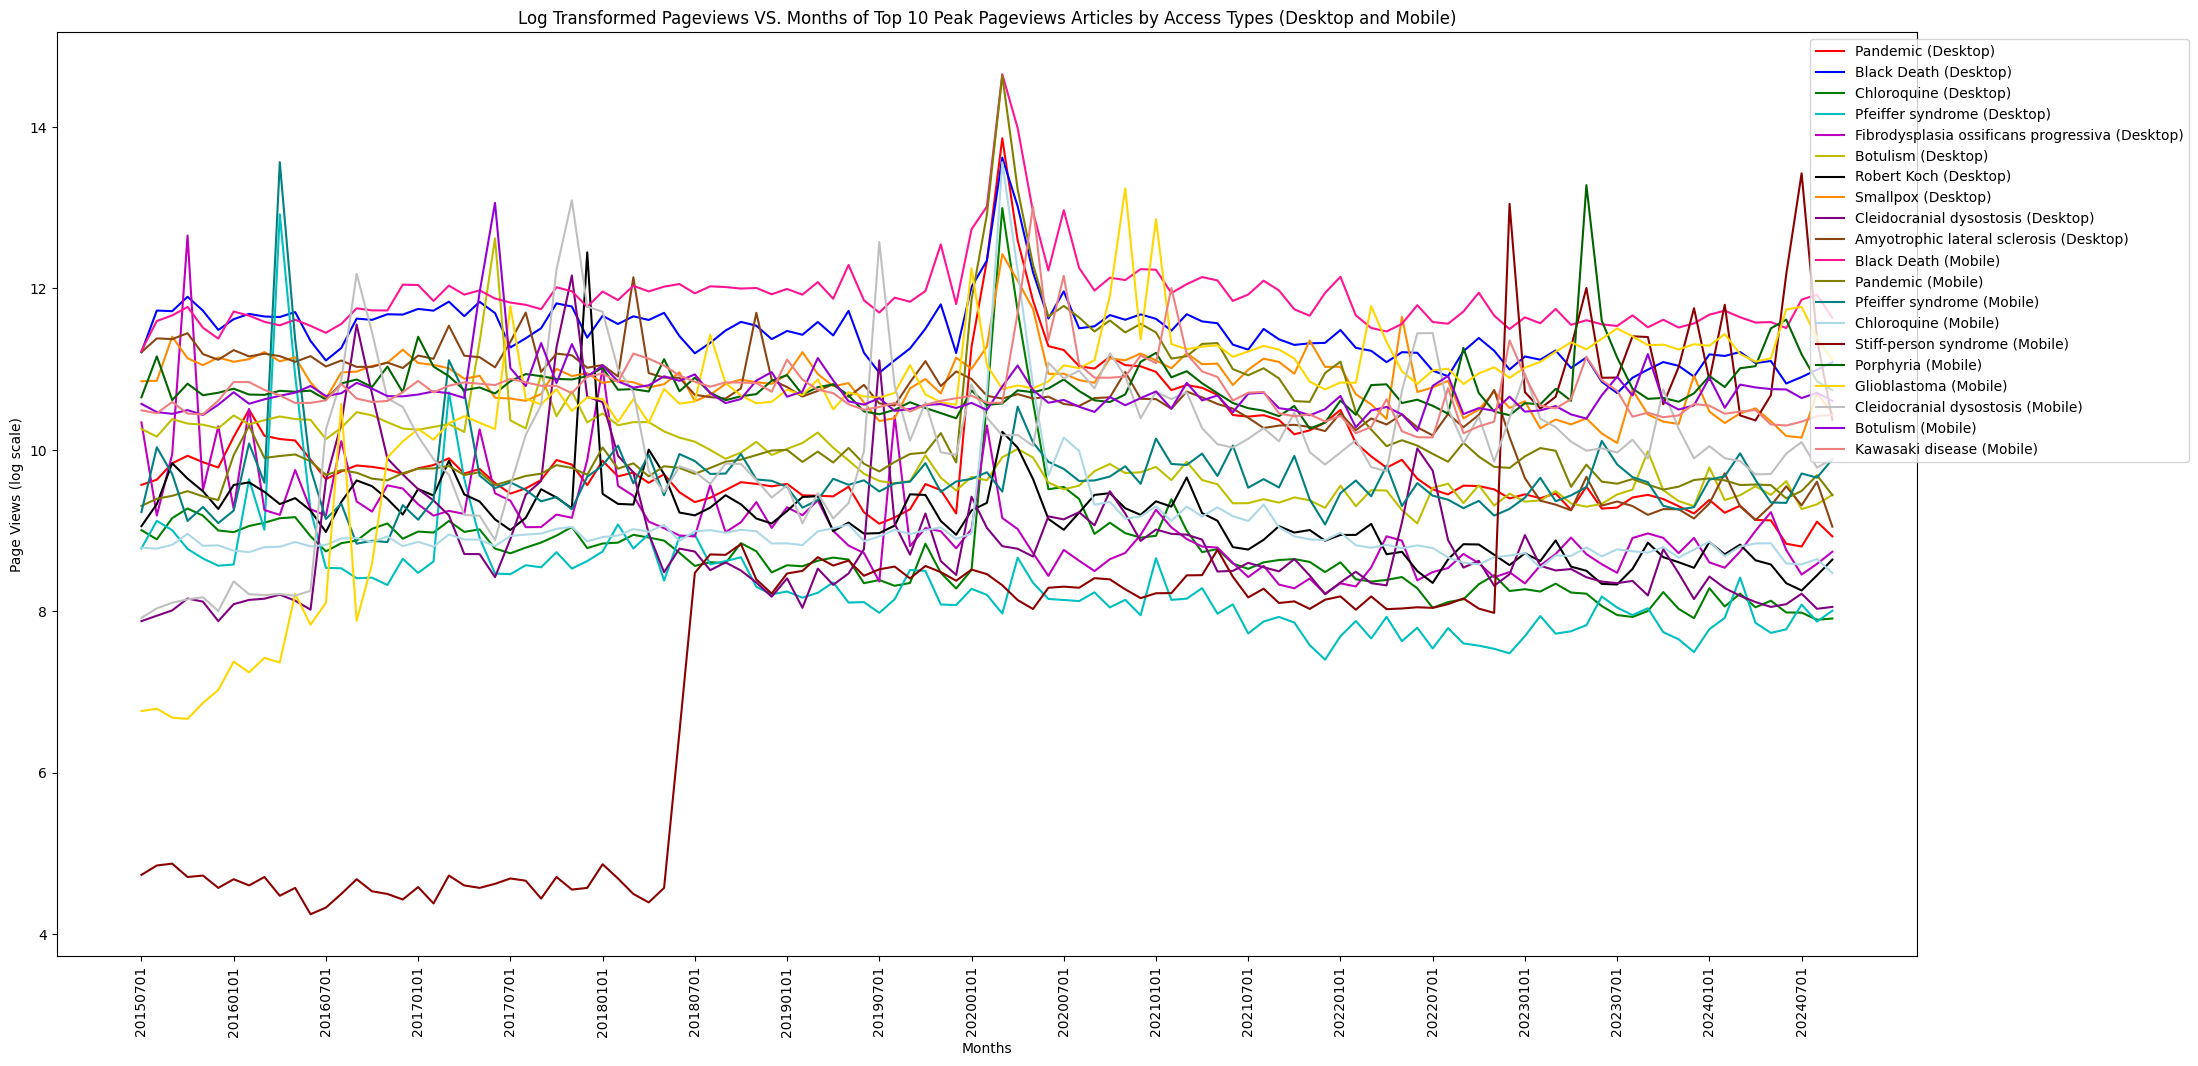

In [61]:
# get the months (x-axis) of all rare diseases
months = [article['timestamp'][:-2] for article in article_desktop_dict['Pandemic']]

# desktop log transformed article pageviews
pand_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Pandemic']]
bd_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Black Death']]
c_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Chloroquine']]
ps_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Pfeiffer syndrome']]
fop_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Fibrodysplasia ossificans progressiva']]
b_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Botulism']]
rk_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Robert Koch']]
s_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Smallpox']]
cd_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Cleidocranial dysostosis']]
als_dt = [math.log(article['views']) if article['views'] else 0 for article in article_desktop_dict['Amyotrophic lateral sclerosis']]

# mobile log transformed article pageviews
bd_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Black Death']]
pan_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Pandemic']]
ps_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Pfeiffer syndrome']]
c_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Chloroquine']]
sps_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Stiff-person syndrome']]
p_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Porphyria']]
g_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Glioblastoma']]
cd_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Cleidocranial dysostosis']]
b_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Botulism']]
kd_mo = [math.log(article['views']) if article['views'] else 0 for article in article_mobile_dict['Kawasaki disease']]

# 20 colors for each article
colors = [
    'r', 'b', 'g', 'c', 'm', 'y', 'k', '#FF8C00', '#800080', '#8B4513',
    '#FF1493', '#808000', '#008080', '#ADD8E6', '#8B0000', '#006400', 
    '#FFD700', '#C0C0C0', '#9400D3', '#F08080'
]

datasets = [pand_dt, bd_dt, c_dt, ps_dt, fop_dt, b_dt, rk_dt, s_dt, cd_dt, als_dt, 
            bd_mo, pan_mo, ps_mo, c_mo, sps_mo, p_mo, g_mo, cd_mo, b_mo, kd_mo]

labels = [
    'Pandemic (Desktop)', 'Black Death (Desktop)', 'Chloroquine (Desktop)',
    'Pfeiffer syndrome (Desktop)', 'Fibrodysplasia ossificans progressiva (Desktop)',
    'Botulism (Desktop)', 'Robert Koch (Desktop)', 'Smallpox (Desktop)',
    'Cleidocranial dysostosis (Desktop)', 'Amyotrophic lateral sclerosis (Desktop)',
    'Black Death (Mobile)', 'Pandemic (Mobile)', 'Pfeiffer syndrome (Mobile)', 'Chloroquine (Mobile)', 'Stiff-person syndrome (Mobile)',
    'Porphyria (Mobile)', 'Glioblastoma (Mobile)', 'Cleidocranial dysostosis (Mobile)', 'Botulism (Mobile)', 'Kawasaki disease (Mobile)'
]

fig, ax1 = plt.subplots(figsize=(24, 12))

for i in range(len(datasets)):
    ax1.plot(months, datasets[i], label=labels[i], color=colors[i], linestyle='-')

# Add legend and show the plot
ax1.set_xlabel('Months')
ax1.set_ylabel('Page Views (log scale)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Log Transformed Pageviews VS. Months of Top 10 Peak Pageviews Articles by Access Types (Desktop and Mobile)')

ticks_to_display = range(0, len(months), 6)  # Every 5th tick
plt.xticks(ticks_to_display, [months[i] for i in ticks_to_display], rotation=90)


plt.show()

### Fewest Months of Data
The third graph shows pages that have the fewest months of available data. The graph shows the **10 articles with the fewest months of data for desktop access** and the **10 articles with the fewest months of data for mobile access**.

find_articles_with_least_data takes either **article_desktop_dict** or **article_mobile_dict** and return a dictionary of number of months of available pageview data for each article depending on the access type.

Returns 
```
{article title: number of months of available data}
```

In [36]:
def find_articles_with_least_data(article_dict):
    """
    Return availble data (in number of months) each article has 
    """
    article_with_least_data = {}
    for article, article_page_view_per_month in article_dict.items():
        article_with_least_data[article] = len(article_page_view_per_month)
    return article_with_least_data

Number of months of available data for each article using desktop access \
Sort the resulting **article_desktop_with_least_data** and access the top 10 articles with the least months of available data using desktop access

In [37]:
article_desktop_with_least_data = find_articles_with_least_data(article_desktop_dict)
top_10_article_with_least_data_desktop = list(sorted(article_desktop_with_least_data.items(), key=lambda x: x[1]))[:10]
top_10_article_with_least_data_desktop

[('Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations',
  33),
 ('Filippi Syndrome', 34),
 ('COVID-19 vaccine misinformation and hesitancy', 37),
 ('CDKL5 deficiency disorder', 40),
 ('Joseph Vinetz', 40),
 ('Spongy degeneration of the central nervous system', 41),
 ('Deaf plus', 41),
 ('Hemolytic jaundice', 41),
 ('Bradley Monk', 41),
 ('Ellis–Van Creveld syndrome', 44)]

Number of months of available data for each article using mobile (mobile-app & mobile-web) access \
Sort the resulting **article_mobile_with_least_data** and access the top 10 articles with the least months of available data using mobile access

In [38]:
article_mobile_with_least_data = find_articles_with_least_data(article_mobile_dict)
top_10_article_with_least_data_mobile = list(sorted(article_mobile_with_least_data.items(), key=lambda x: x[1]))[:10]
top_10_article_with_least_data_mobile

[('Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations',
  33),
 ('Filippi Syndrome', 34),
 ('COVID-19 vaccine misinformation and hesitancy', 37),
 ('CDKL5 deficiency disorder', 40),
 ('Joseph Vinetz', 40),
 ('Spongy degeneration of the central nervous system', 41),
 ('Deaf plus', 41),
 ('Hemolytic jaundice', 41),
 ('Bradley Monk', 41),
 ('Ellis–Van Creveld syndrome', 44)]

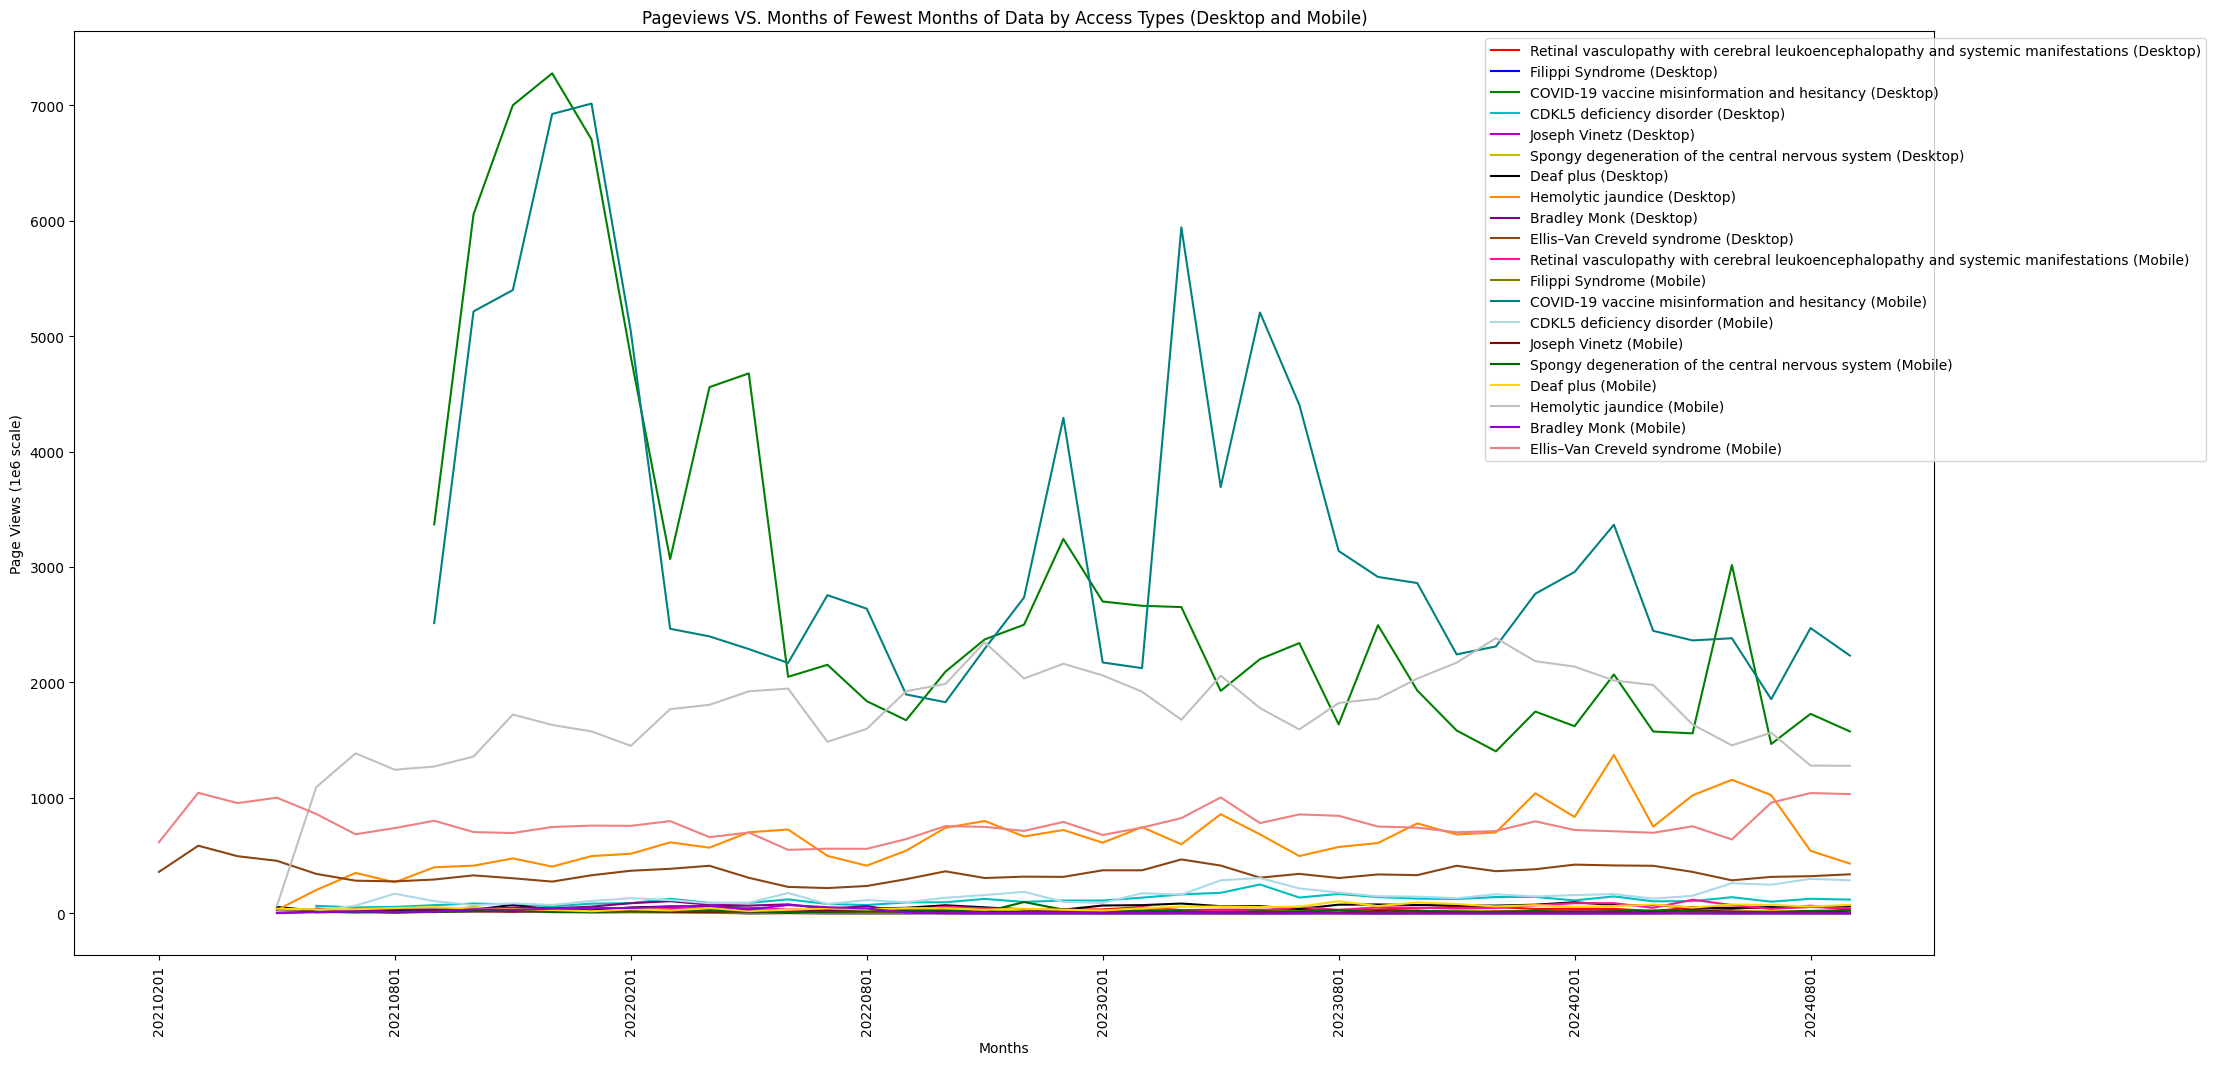

In [62]:
# get the months (x-axis) of all rare diseases
rv_months = [article['timestamp'][:-2] for article in article_desktop_dict['Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations']]
fs_months = [article['timestamp'][:-2] for article in article_desktop_dict['Filippi Syndrome']]
cov_months = [article['timestamp'][:-2] for article in article_desktop_dict['COVID-19 vaccine misinformation and hesitancy']]
cdd_months = [article['timestamp'][:-2] for article in article_desktop_dict['CDKL5 deficiency disorder']]
jv_months = [article['timestamp'][:-2] for article in article_desktop_dict['Joseph Vinetz']]
sd_months = [article['timestamp'][:-2] for article in article_desktop_dict['Spongy degeneration of the central nervous system']]
dp_months = [article['timestamp'][:-2] for article in article_desktop_dict['Deaf plus']]
hj_months = [article['timestamp'][:-2] for article in article_desktop_dict['Hemolytic jaundice']]
bm_months = [article['timestamp'][:-2] for article in article_desktop_dict['Bradley Monk']]
evcs_months = [article['timestamp'][:-2] for article in article_mobile_dict['Ellis–Van Creveld syndrome']]
rv_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations']]
fs_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Filippi Syndrome']]
cov_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['COVID-19 vaccine misinformation and hesitancy']]
cdd_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['CDKL5 deficiency disorder']]
jv_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Joseph Vinetz']]
sd_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Spongy degeneration of the central nervous system']]
dp_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Deaf plus']]
hj_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Hemolytic jaundice']]
bm_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Bradley Monk']]
evcs_m_months = [article['timestamp'][:-2] for article in article_mobile_dict['Ellis–Van Creveld syndrome']]

# desktop article pageviews for the top 10 rare disease with the least months of available data
rv_desktop = [article['views'] for article in article_desktop_dict['Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations']]
fs_desktop = [article['views'] for article in article_desktop_dict['Filippi Syndrome']]
cov_desktop = [article['views'] for article in article_desktop_dict['COVID-19 vaccine misinformation and hesitancy']]
cdd_desktop = [article['views'] for article in article_desktop_dict['CDKL5 deficiency disorder']]
jv_desktop = [article['views'] for article in article_desktop_dict['Joseph Vinetz']]
sd_desktop = [article['views'] for article in article_desktop_dict['Spongy degeneration of the central nervous system']]
dp_desktop = [article['views'] for article in article_desktop_dict['Deaf plus']]
hj_desktop = [article['views'] for article in article_desktop_dict['Hemolytic jaundice']]
bm_desktop = [article['views'] for article in article_desktop_dict['Bradley Monk']]
evcs_desktop = [article['views'] for article in article_desktop_dict['Ellis–Van Creveld syndrome']]

# mobile article pageviews for the top 10 rare disease with the least months of available data
rv_mob = [article['views'] for article in article_mobile_dict['Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations']]
fs_mob = [article['views'] for article in article_mobile_dict['Filippi Syndrome']]
cov_mob = [article['views'] for article in article_mobile_dict['COVID-19 vaccine misinformation and hesitancy']]
cdd_mob = [article['views'] for article in article_mobile_dict['CDKL5 deficiency disorder']]
jv_mob = [article['views'] for article in article_mobile_dict['Joseph Vinetz']]
sd_mob = [article['views'] for article in article_mobile_dict['Spongy degeneration of the central nervous system']]
dp_mob = [article['views'] for article in article_mobile_dict['Deaf plus']]
hj_mob = [article['views'] for article in article_mobile_dict['Hemolytic jaundice']]
bm_mob = [article['views'] for article in article_mobile_dict['Bradley Monk']]
evcs_mob = [article['views'] for article in article_mobile_dict['Ellis–Van Creveld syndrome']]

# months for x-axis
months = [
    rv_months, fs_months, cov_months, cdd_months, jv_months, sd_months, dp_months, hj_months, bm_months, evcs_months,
    rv_m_months, fs_m_months, cov_m_months, cdd_m_months, jv_m_months, sd_m_months, dp_m_months, hj_m_months, bm_m_months, evcs_m_months
]
# 20 colors for each article
colors = [
    'r', 'b', 'g', 'c', 'm', 'y', 'k', '#FF8C00', '#800080', '#8B4513',
    '#FF1493', '#808000', '#008080', '#ADD8E6', '#8B0000', '#006400', 
    '#FFD700', '#C0C0C0', '#9400D3', '#F08080'
]

datasets = [rv_desktop, fs_desktop, cov_desktop, cdd_desktop, jv_desktop, sd_desktop, dp_desktop, hj_desktop, bm_desktop, evcs_desktop,
            rv_mob, fs_mob, cov_mob, cdd_mob, jv_mob, sd_mob, dp_mob, hj_mob, bm_mob, evcs_mob]

labels = [
    'Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations (Desktop)', 
    'Filippi Syndrome (Desktop)', 'COVID-19 vaccine misinformation and hesitancy (Desktop)',
    'CDKL5 deficiency disorder (Desktop)', 'Joseph Vinetz (Desktop)',
    'Spongy degeneration of the central nervous system (Desktop)', 'Deaf plus (Desktop)', 'Hemolytic jaundice (Desktop)',
    'Bradley Monk (Desktop)', 'Ellis–Van Creveld syndrome (Desktop)',
    'Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations (Mobile)', 
    'Filippi Syndrome (Mobile)', 'COVID-19 vaccine misinformation and hesitancy (Mobile)', 'CDKL5 deficiency disorder (Mobile)', 
    'Joseph Vinetz (Mobile)', 'Spongy degeneration of the central nervous system (Mobile)', 'Deaf plus (Mobile)', 
    'Hemolytic jaundice (Mobile)', 'Bradley Monk (Mobile)', 'Ellis–Van Creveld syndrome (Mobile)'
]

# Create a unified timeline of all months across all datasets
all_months = sorted(set(month for sublist in months for month in sublist))  # This collects and sorts all unique months

# Now, ensure each dataset aligns with the unified timeline
aligned_datasets = []
for i in range(len(datasets)):
    # Create a DataFrame to align the months and data
    df = pd.DataFrame({'month': months[i], 'views': datasets[i]})
    df = df.set_index('month')  # Set month as the index
    df = df.reindex(all_months, fill_value=None)  # Align to the unified timeline and fill missing values with None
    aligned_datasets.append(df['views'].tolist())  # Convert back to a list

# Now, plot the aligned datasets using the unified months
fig, ax1 = plt.subplots(figsize=(24, 12))

for i in range(len(aligned_datasets)):
    ax1.plot(all_months, aligned_datasets[i], label=labels[i], color=colors[i], linestyle='-')

# Add legend and show the plot
ax1.set_xlabel('Months')
ax1.set_ylabel('Page Views (1e6 scale)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Pageviews VS. Months of Fewest Months of Data by Access Types (Desktop and Mobile)')

ticks_to_display = range(0, len(all_months), 6)  # Adjust based on your preferred tick display
plt.xticks(ticks_to_display, [all_months[i] for i in ticks_to_display], rotation=90)

plt.show()